**Loading the Dataset and assigning to clients**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np


# Loading Dataset: (CIFAR-10)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


#============================ Different Datasets to experiment with =======================
# Dataset (FMNIST)
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# For ResNet18: Dataset (MNIST)
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#x_train, y_train = x_train[:50000], y_train[:50000]

#==========================================================================================


x_train, x_test = x_train.astype("float32"), x_test.astype("float32")
y_train, y_test = y_train.flatten(), y_test.flatten()


# Split Data among clients

num_clients = 5
data_per_client = len(x_train) // num_clients
print(data_per_client)
client_data = [(x_train[i * data_per_client:(i + 1) * data_per_client],
                y_train[i * data_per_client:(i + 1) * data_per_client])
               for i in range(num_clients)]

input_shape = (32, 32, 3) # for Cifar-10 dataset
#input_shape = (28,28,1) # for mnist and fmnist datasets

num_classes = 10 # All 3 datasets contains 10 image classes/labels
batch_size = 64
epochs = 20

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
10000


**Building the Model**

In [2]:
#LeNet Model Architecture

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense

def build_model(input_shape= input_shape, num_classes=10):

    with tf.device('/cpu:0'):
    #with tf.device('/gpu:0'):         #Comment previous line and uncomment this one if you have access to GPU (training will be faster)

        inputs = Input(shape=input_shape)
        # C1: 6 filters, 5x5, tanh
        x = Conv2D(6, (5, 5), activation='tanh', padding='valid', name='C1')(inputs)
        # S2: Average pooling 2x2, stride 2
        x = AveragePooling2D(pool_size=(2, 2), name='S2')(x)
        # C3: 16 filters, 5x5, tanh
        x = Conv2D(16, (5, 5), activation='tanh', padding='valid', name='C3')(x)
        # S4: Average pooling 2x2, stride 2
        x = AveragePooling2D(pool_size=(2, 2), name='S4')(x)
        # Flatten
        x = Flatten(name='Flatten')(x)
        # F5: Dense 120, tanh
        x = Dense(120, activation='tanh', name='F5')(x)
        # F6: Dense 84, tanh
        x = Dense(84, activation='tanh', name='F6')(x)
        # Output: Softmax for 10 classes
        outputs = Dense(num_classes, activation='softmax', name='Output')(x)

    return Model(inputs, outputs, name='LeNet-5_CIFAR10')

In [ ]:
# AlexNet Model Architecture
# AlexNet is complex model and will take more time to train. But it will also show better accuracy
# Load this instead of LeNet to use AlexNet for all clients


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(input_shape=input_shape, num_classes=10):

    #with tf.device('/cpu:0'):
    with tf.device('/gpu:0'):           # Complex Model Architecture, Running on GPU will reduce training time significantly

        inputs = Input(shape=input_shape)
        # Conv1: 32 filters (original: 96), 5x5, stride=1
        x = Conv2D(32, (5, 5), strides=1, activation='relu', padding='same', name='Conv1')(inputs)
        # Conv2: 64 filters (original: 256), 3x3
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2')(x)
        x = MaxPooling2D(pool_size=(2, 2), name='Pool2')(x)
        # Conv3-5: 64 filters (original: 384/256)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv5')(x)
        x = MaxPooling2D(pool_size=(2, 2), name='Pool3')(x)
        # Flatten
        x = Flatten(name='Flatten')(x)
        # Dense layers: 512 units (original: 4096)
        x = Dense(512, activation='relu', name='FC1')(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu', name='FC2')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax', name='Output')(x)
    return Model(inputs, outputs, name='AlexNet_FashionMNIST_Light')


In [3]:
import time

global_accs = []
global_models = []

#def evaluate_global_model(model):
#    logits = model(x_test, training=False)
#    preds = tf.argmax(logits, axis=1)
#    acc = tf.reduce_mean(tf.cast(tf.equal(preds, y_test), tf.float32))
#    global_accs.append(acc)
#    print(f"Global Test Accuracy: {acc.numpy():.4f}")

def evaluate_global_model(model):
    batch_size = 512
    num_samples = len(x_test)
    preds = []
    for i in range(0, num_samples, batch_size):
        batch_x = x_test[i:i+batch_size]
        logits = model(batch_x, training=False)
        batch_preds = tf.argmax(logits, axis=1)
        preds.extend(batch_preds.numpy())
    preds = tf.convert_to_tensor(preds)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, y_test), tf.float32))
    global_accs.append(acc)
    print(f"Global Test Accuracy: {acc.numpy():.4f}")

# Training
models = []
for _ in range(num_clients):
    model = build_model()  # build the model without splitting
    models.append(model)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)
optimizers = [tf.keras.optimizers.Adam(learning_rate=lr_schedule) for _ in range(num_clients)]

# FedAvg
def average_trainable_weights_weighted(model_list, sample_counts):
    new_weights = []
    total_samples = sum(sample_counts)
    for weights in zip(*[model.trainable_weights for model in model_list]):
        weighted_sum = sum(w.numpy() * (count / total_samples)
                           for w, count in zip(weights, sample_counts))
        new_weights.append(weighted_sum)
    return new_weights

def set_trainable_weights(model, new_weights):
    for var, new in zip(model.trainable_weights, new_weights):
        var.assign(new)

client_accuracies = [[] for _ in range(num_clients)]
client_time = [[] for _ in range(num_clients)]

# Training loop
for epoch in range(epochs):
    print(f"\n🌀 Epoch {epoch + 1}/{epochs}")

    for client_id, (x_client, y_client) in enumerate(client_data):
        start_time = time.time()

        train_ds = tf.data.Dataset.from_tensor_slices((x_client, y_client)).shuffle(1000).batch(batch_size)
        model = models[client_id]

        for step, (x_batch, y_batch) in enumerate(train_ds):
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss = loss_fn(y_batch, logits)
                acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=1), tf.cast(y_batch, tf.int64)), tf.float32))

            grads = tape.gradient(loss, model.trainable_variables)
            optimizers[client_id].apply_gradients(zip(grads, model.trainable_variables))

            if step % 100 == 0:
                print(f"Client {client_id}, Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc.numpy():.4f}")

            client_accuracies[client_id].append(acc.numpy())

        end_time = time.time()
        print(f"Time taken: {end_time - start_time}")

    sample_counts = [len(data[0]) for data in client_data]
    avg_weights = average_trainable_weights_weighted(models, sample_counts)

    for model in models:
        set_trainable_weights(model, avg_weights)

    global_models.append(models[0])
    evaluate_global_model(models[0])


🌀 Epoch 1/20
Client 0, Step 0, Loss: 2.4222, Accuracy: 0.0469
Client 0, Step 100, Loss: 2.1145, Accuracy: 0.2969
Time taken: 19.11538314819336
Client 1, Step 0, Loss: 2.3541, Accuracy: 0.1094
Client 1, Step 100, Loss: 1.9340, Accuracy: 0.3281
Time taken: 19.712511777877808
Client 2, Step 0, Loss: 2.6089, Accuracy: 0.0781
Client 2, Step 100, Loss: 1.9789, Accuracy: 0.3281
Time taken: 19.130707263946533
Client 3, Step 0, Loss: 2.3744, Accuracy: 0.1406
Client 3, Step 100, Loss: 1.8116, Accuracy: 0.2969
Time taken: 20.16048002243042
Client 4, Step 0, Loss: 2.4512, Accuracy: 0.0156
Client 4, Step 100, Loss: 1.9518, Accuracy: 0.2344
Time taken: 18.283838510513306
Global Test Accuracy: 0.1508

🌀 Epoch 2/20
Client 0, Step 0, Loss: 2.3017, Accuracy: 0.1250
Client 0, Step 100, Loss: 2.0745, Accuracy: 0.2656
Time taken: 18.42818784713745
Client 1, Step 0, Loss: 2.2817, Accuracy: 0.1875
Client 1, Step 100, Loss: 2.1890, Accuracy: 0.2031
Time taken: 17.775081396102905
Client 2, Step 0, Loss: 2.290

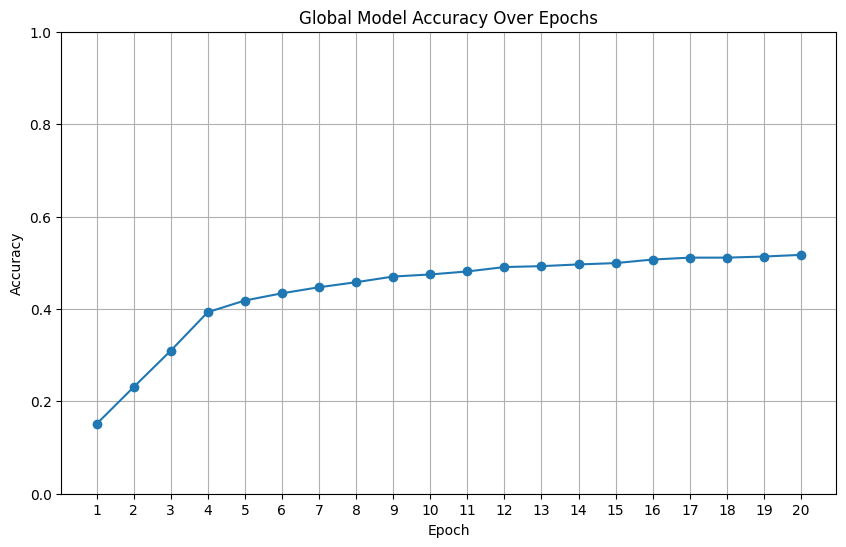

In [4]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 6))
plt.plot(range(1, len(global_accs) + 1), global_accs, marker='o', linestyle='-')
plt.title('Global Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(1, len(global_accs) + 1))
plt.ylim(0, 1)
plt.show()
